In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
np.random.seed(seed=0)
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
sns.set_style("whitegrid", rc={'font.family': 'Times New Roman', 'font.size': 16})

from constants import LOCATION_CHOOSEN, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

df['date'] = pd.to_datetime(df['date'])
# creating new columns
df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

In [3]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return outliers

print(detect_outlier(df['S']), detect_outlier(df['I']), detect_outlier(df['R']))

[] [] []


In [4]:
print(df.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'date',
       'stringency_index', 'total_cases', 'total_deaths', 'total_vaccinations',
       'population', 'people_fully_vaccinated', 'gdp_normalized',
       'gdp_normalized_modelled', 'N', 'S', 'I', 'R',
       'S_modelled_without_lockdown', 'I_modelled_without_lockdown',
       'R_modelled_without_lockdown', 'r_eff_actual_without_lockdown',
       'r_eff_modelled_without_lockdown', 'S_modelled_with_lockdown',
       'I_modelled_with_lockdown', 'R_modelled_with_lockdown',
       'r_eff_modelled_with_lockdown', 'r_eff_actual_with_lockdown'],
      dtype='object')


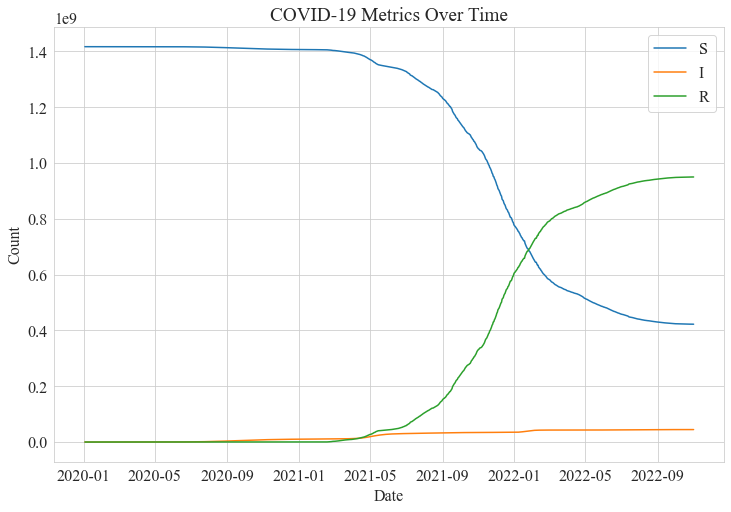

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

## Without Lockdown

In [6]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    # mse
    return np.square(data - predictions).mean()

def compute_cost(data, predictions):
    # mae
    return np.abs(data - predictions).mean()

def compute_cost(data, predictions, delta=1.0):
    # Huber loss
    residual = np.abs(data - predictions)
    condition = residual < delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return np.where(condition, squared_loss, linear_loss).mean()

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [7]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.07565820733562756 optimal_gamma: 0.046594691406826524
optimal_beta/optimal_gamma: 1.6237516560640421


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


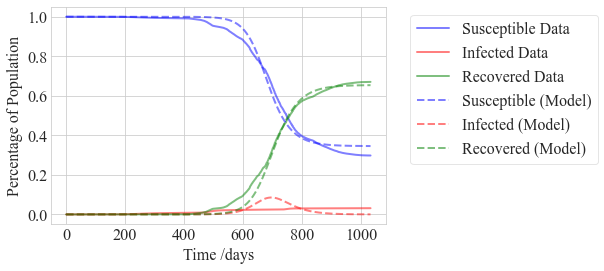

cost_without_lockdown: 69949738.9977647


In [8]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_without_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

In [9]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_without_lockdown"] = S
df["I_modelled_without_lockdown"] = I
df["R_modelled_without_lockdown"] = R
df["r_eff_actual_without_lockdown"] = r0 * df["S"]/df["N"]
df["r_eff_modelled_without_lockdown"] = r0 * df["S_modelled_without_lockdown"]/df["N"]

## With Lockdown

In [10]:
def deriv(y, t, N, beta, gamma, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    # mse
    return np.square(data - predictions).mean()

def compute_cost(data, predictions):
    # mae
    return np.abs(data - predictions).mean()

def compute_cost(data, predictions, delta=1.0):
    # Huber loss
    residual = np.abs(data - predictions)
    condition = residual < delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return np.where(condition, squared_loss, linear_loss).mean()

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [11]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.302941346409129 optimal_gamma: 0.07020572542840187
optimal_beta/optimal_gamma: 4.315051864510377


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


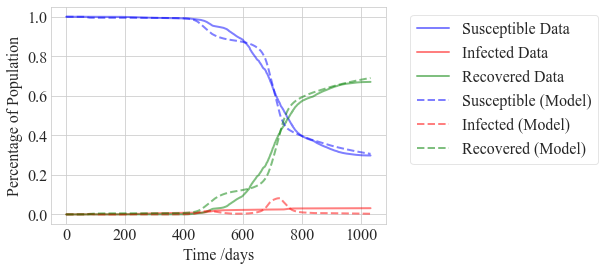

cost_with_lockdown: 68015990.34546319


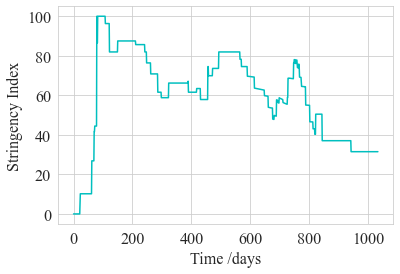

In [12]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, lockdown))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time /days')
plt.ylabel('Stringency Index')
plt.grid(True)

cost_with_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_with_lockdown: {cost_with_lockdown}")

## Decrease in cost by modelling Lockdown

In [13]:
print(f"difference in cost for with/without lockdown: {cost_without_lockdown - cost_with_lockdown}")

difference in cost for with/without lockdown: 1933748.65230152


In [14]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [15]:
print(df.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'date',
       'stringency_index', 'total_cases', 'total_deaths', 'total_vaccinations',
       'population', 'people_fully_vaccinated', 'gdp_normalized',
       'gdp_normalized_modelled', 'N', 'S', 'I', 'R',
       'S_modelled_without_lockdown', 'I_modelled_without_lockdown',
       'R_modelled_without_lockdown', 'r_eff_actual_without_lockdown',
       'r_eff_modelled_without_lockdown', 'S_modelled_with_lockdown',
       'I_modelled_with_lockdown', 'R_modelled_with_lockdown',
       'r_eff_modelled_with_lockdown', 'r_eff_actual_with_lockdown'],
      dtype='object')


In [16]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown"] = S
df["I_modelled_with_lockdown"] = I
df["R_modelled_with_lockdown"] = R
df["r_eff_modelled_with_lockdown"] = r0 * df["S_modelled_with_lockdown"]/df["N"]
df["r_eff_actual_with_lockdown"] = r0 * df["S"]/df["N"]

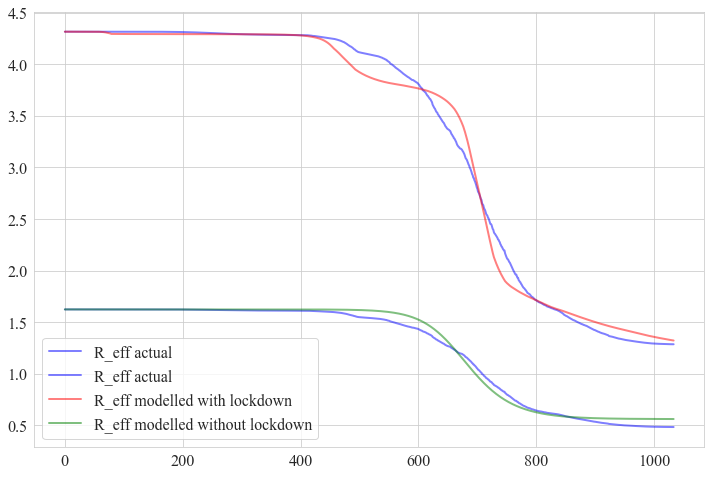

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(t, df['r_eff_actual_with_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_actual_without_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_modelled_with_lockdown'], 'r', alpha=0.5, lw=2, label='R_eff modelled with lockdown')
plt.plot(t, df['r_eff_modelled_without_lockdown'], 'g', alpha=0.5, lw=2, label='R_eff modelled without lockdown')
plt.legend()

In [18]:
from scipy.spatial.distance import cosine
print(1 - cosine(df["r_eff_actual_without_lockdown"], df["r_eff_modelled_without_lockdown"]))
print(1 - cosine(df["r_eff_actual_with_lockdown"], df["r_eff_modelled_with_lockdown"]))

0.9994706441392616
0.999537635356316


In [19]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [20]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [21]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'date',
       'stringency_index', 'total_cases', 'total_deaths', 'total_vaccinations',
       'population', 'people_fully_vaccinated', 'gdp_normalized',
       'gdp_normalized_modelled', 'N', 'S', 'I', 'R',
       'S_modelled_without_lockdown', 'I_modelled_without_lockdown',
       'R_modelled_without_lockdown', 'r_eff_actual_without_lockdown',
       'r_eff_modelled_without_lockdown', 'S_modelled_with_lockdown',
       'I_modelled_with_lockdown', 'R_modelled_with_lockdown',
       'r_eff_modelled_with_lockdown', 'r_eff_actual_with_lockdown'],
      dtype='object')

In [22]:
print(max(df['gdp_normalized']), min(df['gdp_normalized']))

df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
# here modelled means with gdp modelled with stringency
df['gdp_normalized_modelled_min_max_normalized'] =  (df['gdp_normalized_modelled'] - MIN_GDP) / (MAX_GDP - MIN_GDP)

100.573650833479 83.9054327862878


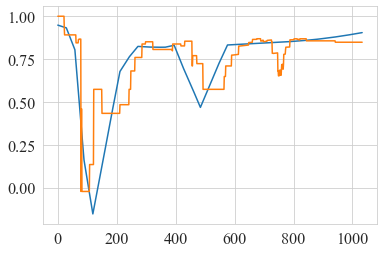

In [23]:
plt.plot(df['gdp_min_max_normalized'])
plt.plot(df['gdp_normalized_modelled_min_max_normalized'])

In [24]:
df.diff()['stringency_index'][1:].describe()

count    1033.000000
mean        0.030474
std         2.387331
min       -14.360000
25%         0.000000
50%         0.000000
75%         0.000000
max        55.560000
Name: stringency_index, dtype: float64

In [47]:
actions_taken = []
with open("actions_taken.txt", "r") as f:
    for line in f:
        actions_taken.append(int(line.strip()))
start_stringency = 0.0
current_stringency_index = start_stringency
stringency_index_from_actions_taken = [current_stringency_index]

for action in actions_taken:
    reward_inertia_flag = False
    if action == 0:
        current_stringency_index = max(0, current_stringency_index - 10)
    elif action == 1:
        current_stringency_index = max(0, current_stringency_index - 5)
    elif action == 2:
        current_stringency_index = max(0, current_stringency_index - 2.5)
    elif action == 3:
        current_stringency_index = max(0, current_stringency_index + 0)
    elif action == 4:
        current_stringency_index = min(100, current_stringency_index + 2.5)
    elif action == 5:
        current_stringency_index = min(100, current_stringency_index + 5)
    elif action == 6:
        current_stringency_index = min(100, current_stringency_index + 10)
    stringency_index_from_actions_taken.append(current_stringency_index)
        
stringency_index_from_actions_taken = np.array(stringency_index_from_actions_taken)

In [48]:
print(actions_taken[:10])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [53]:
def reward_strategy(stringency_moves, reward_strategy_choosen, sir_technique):   
    N = df.loc[min(df.index), ['N']].item()
    y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
    days_difference = (max(df['date']) - min(df['date'])).days
    t = np.linspace(0, days_difference, days_difference + 1)
    
    stringency_index_random_choice = []
    store_S = np.zeros(days_difference + 1)
    store_I = np.zeros(days_difference + 1)
    store_R = np.zeros(days_difference + 1)

    # sir_technique 1 is faster
    # 2 is just to check whether the results match with 1
    moves_lockdown = stringency_index_from_actions_taken / 100
    if sir_technique == 1:
        moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, moves_lockdown))
        moves_S, moves_I, moves_R = moves_ret.T

        df["S_moves"] = moves_S
        df["I_moves"] = moves_I
        df["R_moves"] = moves_R
    elif sir_technique == 2:
        for ith_day in range(days_difference + 1):
            stringency_index_random_choice.append(stringency_index_from_actions_taken[ith_day])
            t = np.linspace(0, ith_day, ith_day + 1)
            moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, np.array(stringency_index_random_choice) / 100))
            moves_S, moves_I, moves_R = moves_ret.T
            store_S[ith_day] = moves_S[-1]
            store_I[ith_day] = moves_I[-1]
            store_R[ith_day] = moves_R[-1]
        df["S_moves"] = store_S
        df["I_moves"] = store_I
        df["R_moves"] = store_R
    
    df["r_eff_moves_with_lockdown"] = r0 * df["S_moves"]/df["N"]
    df["gdp_normalized_moves_min_max_normalized"] = ((fit_line_loaded(stringency_index_from_actions_taken) - MIN_GDP) / (MAX_GDP - MIN_GDP))[:-1]
    
    modelled_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, (df['stringency_index']) / 100))
    modelled_S, modelled_I, modelled_R = modelled_ret.T
    
    df["S_modelled_with_lockdown_inside_plot"] = modelled_S
    df["I_modelled_with_lockdown_inside_plot"] = modelled_I
    df["R_modelled_with_lockdown_inside_plot"] = modelled_R
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["S_modelled_with_lockdown_inside_plot"], color='b', label='S_modelled')
    plt.plot(df["I_modelled_with_lockdown_inside_plot"], color='g', label='I_modelled')
    plt.plot(df["R_modelled_with_lockdown_inside_plot"], color='r', label='R_modelled')
    plt.plot(df["S_moves"], 'b--', label='S_moves')
    plt.plot(df["I_moves"], 'g--', label='I_moves')
    plt.plot(df["R_moves"], 'r--', label='R_moves')
    plt.xlabel('days')
    plt.ylabel('Population')
    plt.title('SIR_dynamics')
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['stringency_index'], color='b', label='actual')
    plt.plot(stringency_index_from_actions_taken , color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('stringency')
    plt.title('stringency')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['r_eff_actual_with_lockdown'], color='b', label='actual')
    plt.plot(df['r_eff_modelled_with_lockdown'], color='r', label='modelled')
    plt.plot(df['r_eff_moves_with_lockdown'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('r_eff')
    plt.title('R_eff')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['gdp_min_max_normalized'], color='b', label='actual')
    plt.plot(df['gdp_normalized_modelled_min_max_normalized'], color='r', label='modelled')
    plt.plot(df['gdp_normalized_moves_min_max_normalized'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('gdp')
    plt.title('GDP')
    plt.legend()
    plt.show()
        
    if reward_strategy_choosen == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 2:
        plt.figure(figsize=(10, 6))
        
        index_to_the_power_of = 0.001
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 3:
        
        # we need the epidemic to happen and also the I population to stay below a certain value (beds in the hospital) (10 multiple)
        # we need r_eff to be below 1 at an earlier stage (1 multiple)
        # we need to reward inertia by a small amount (0.1 multiple)
        
        hospital_capacity = 0.08
        hospital_capacity_reward = -20
        I_reward_actual = [0 if I_percentage < hospital_capacity else hospital_capacity_reward for I_percentage in df["I"] / df["N"]]
        I_reward_modelled = [0 if I_percentage < hospital_capacity else hospital_capacity_reward for I_percentage in df["I_modelled_with_lockdown"] / df["N"]]
        I_reward_moves = [0 if I_percentage < hospital_capacity else hospital_capacity_reward for I_percentage in df["I_moves"] / df["N"]]
        
        
        r_eff_reward_actual = [1 if r_eff <= 1 else 0 for r_eff in df["r_eff_actual_with_lockdown"]]
        r_eff_reward_modelled = [1 if r_eff <= 1 else 0 for r_eff in df["r_eff_modelled_with_lockdown"]]
        r_eff_reward_moves = [1 if r_eff <= 1 else 0 for r_eff in df["r_eff_moves_with_lockdown"]]
        
        inertia_rewards_actual = [0] + [abs(diff)*0.1*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        # modelled reward for intertia is same as actual
        inertia_rewards_modelled = [0] + [abs(diff)*0.1*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        inertia_rewards_moves = [abs(diff)*0.1*-1 for diff in (stringency_index_from_actions_taken[i] - stringency_index_from_actions_taken[i - 1] for i in range(1, len(stringency_index_from_actions_taken)))]
        
        # index_to_the_power_of = 0.00001
        # reward_actual = (df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        # reward_modelled = (df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        # reward_moves = df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        # TODO try this...
        def calculate_reward(gdp_normalized, r_eff_actual):
            GDP_WEIGHT = 0.35 # change this value and see how it affects the reward
            if r_eff_actual > 1:
                # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
                return gdp_normalized / (5 * r_eff_actual)
            else:
                # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
                return GDP_WEIGHT * gdp_normalized
            
        plt.plot(reward_actual, color='b', label='reward(actual) = {reward}'.format(reward = np.sum(reward_actual)))
        plt.plot(reward_modelled, color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(reward_modelled)))
        plt.plot(reward_moves, color='g', label='reward(moves) = {reward}'.format(reward = np.sum(reward_moves)))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        

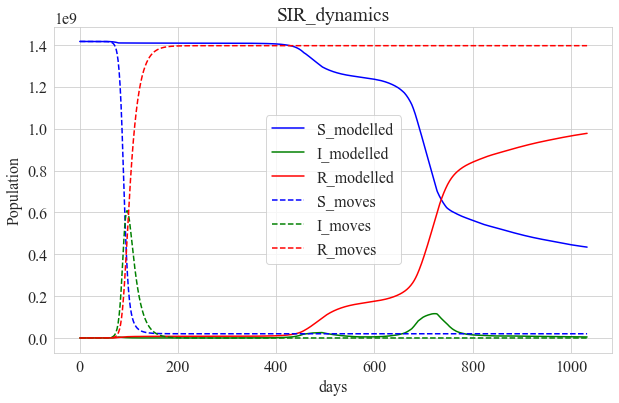

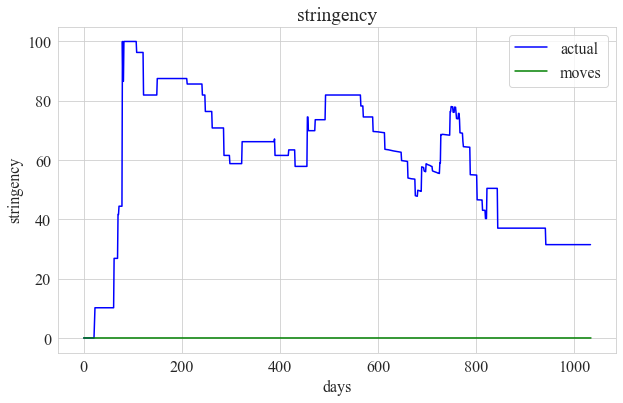

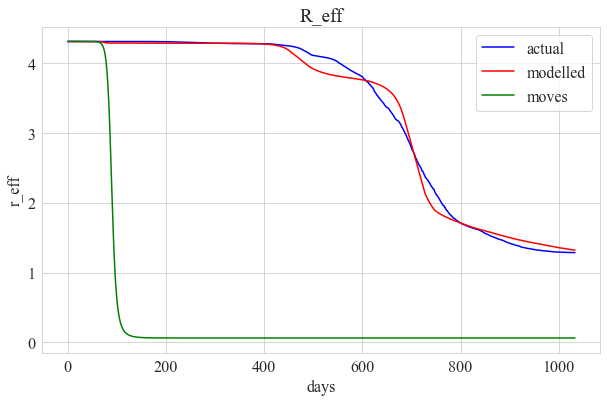

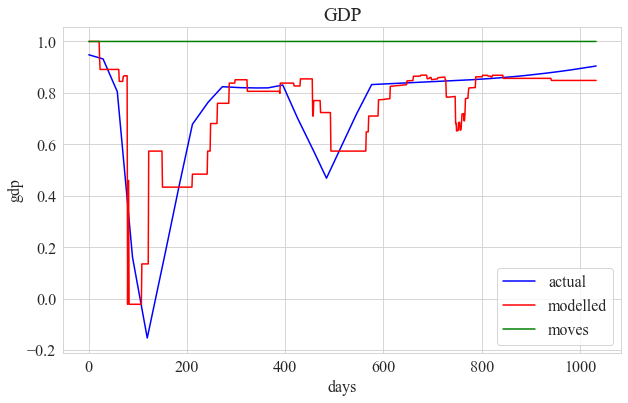

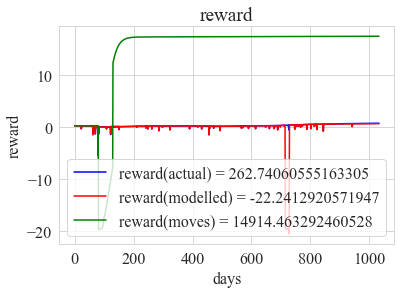

In [54]:
reward_strategy(stringency_index_from_actions_taken, reward_strategy_choosen=3, sir_technique=1)

In [33]:
for I in df["I_modelled_with_lockdown"] / df["N"]:
    if I > 0.08:
        print("yes")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
